# Dog Skin Diseases Classification

The notebook incorporates the model utilized for classifying skin diseases of dogs (3 diseases and 1 healthy class). A customley made datasetspecially for Sri Lanka is used for training, validating and testing the model. The development of the classification model followed a transfer learning approach, using mobileNetV3 Keras application. To assess the performance of the model, several evaluation metrics were employed, including accuracy, F1-score, precision, recall, and evaluation matrix. The output from each metric indicates that the model achieved a high level of accuracy in classifying the eye images.


### Importing required libraries

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import os

In [2]:
TRAIN_PATH = r'E:\Year04\IRP\dataset\organized_data_augment\train'
VAL_PATH = r'E:\Year04\IRP\dataset\organized_data_augment\val'
TEST_PATH = r'E:\Year04\IRP\dataset\organized_data_augment\test'

In [3]:
IMAGE_SIZE = (128, 128)

### Initializing train, validation & test data

In [11]:
# Load datasets with one-hot encoding for labels
training_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=None,
    subset=None,
    shuffle=True,
    batch_size=32,
    image_size=IMAGE_SIZE,
    label_mode='categorical'  # One-hot encoded labels
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_PATH,
    validation_split=None,
    subset=None,
    shuffle=True,
    batch_size=32,
    image_size=IMAGE_SIZE,
    label_mode='categorical'  # One-hot encoded labels
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_PATH,
    validation_split=None,
    subset=None,
    shuffle=False,
    batch_size=32,
    image_size=IMAGE_SIZE,
    label_mode='categorical'  # One-hot encoded labels
)

Found 8795 files belonging to 4 classes.
Found 2513 files belonging to 4 classes.
Found 1257 files belonging to 4 classes.


### Plot Images with labels

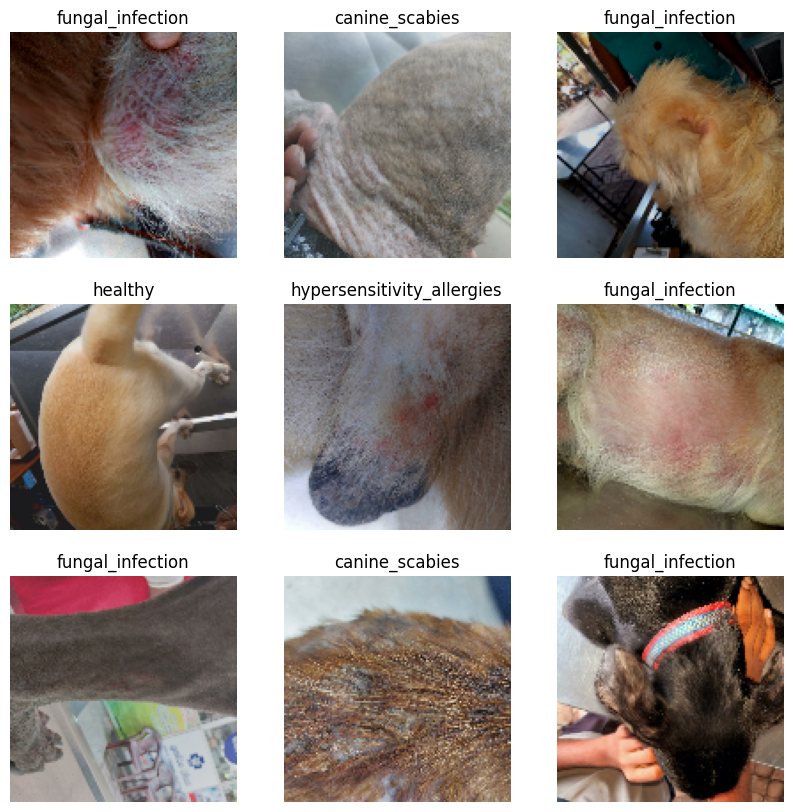

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Let's assume images and labels are from a batch in training_ds
for images, labels in training_ds.take(1):  # Take the first batch
    # Convert one-hot encoded labels to class indices
    class_indices = np.argmax(labels.numpy(), axis=1)
    
    # Plot images with their corresponding labels
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Show the first 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(training_ds.class_names[class_indices[i]])  # Use class indices
        plt.axis("off")
    plt.show()


In [14]:
class_num = 4
input_shape = (128,128,3)

In [15]:
MobileNet_model = MobileNetV3Large(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

# The last 15 layers fine tune
for layer in MobileNet_model.layers[:-15]:
    layer.trainable = False

In [16]:
# Build the model
model = Sequential([
    MobileNet_model,
    GlobalAveragePooling2D(),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')  # 4 classes
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 1, 1, 1280)       4226432   
 l)                                                              
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               327936    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                

In [17]:

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2, min_lr=1e-6)
checkpoint = ModelCheckpoint('mobileNet_best_model.h5', monitor='val_accuracy', save_best_only=True)

In [19]:
# Training
history = model.fit(
    training_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=[early_stop, reduce_lr, checkpoint]
)


Epoch 1/30
275/275 [==============================] - ETA: 0s - loss: 0.9195 - accuracy: 0.6199

c:\anaconda\envs\gpu_py\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


275/275 [==============================] - 208s 728ms/step - loss: 0.9195 - accuracy: 0.6199 - val_loss: 0.5786 - val_accuracy: 0.7736 - lr: 1.0000e-04
Epoch 2/30
275/275 [==============================] - 230s 816ms/step - loss: 0.4748 - accuracy: 0.8230 - val_loss: 0.3765 - val_accuracy: 0.8595 - lr: 1.0000e-04
Epoch 3/30
275/275 [==============================] - 233s 825ms/step - loss: 0.2912 - accuracy: 0.8973 - val_loss: 0.3072 - val_accuracy: 0.8874 - lr: 1.0000e-04
Epoch 4/30
275/275 [==============================] - 277s 987ms/step - loss: 0.1965 - accuracy: 0.9344 - val_loss: 0.2022 - val_accuracy: 0.9272 - lr: 1.0000e-04
Epoch 5/30
275/275 [==============================] - 307s 1s/step - loss: 0.1266 - accuracy: 0.9597 - val_loss: 0.1489 - val_accuracy: 0.9447 - lr: 1.0000e-04
Epoch 6/30
275/275 [==============================] - 284s 1s/step - loss: 0.0851 - accuracy: 0.9745 - val_loss: 0.1121 - val_accuracy: 0.9602 - lr: 1.0000e-04
Epoch 7/30
275/275 [===================

### Plot Accuracy & Loss graphs

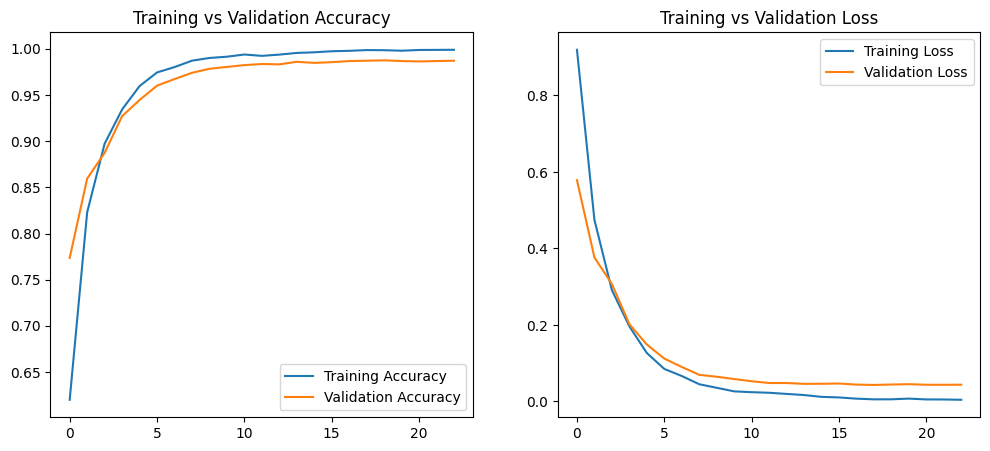

In [20]:
# Evaluation
# Plot Training vs Validation Accuracy and Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'] , label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()

### Train, Validation & Test accuracy from saved model

In [22]:
from keras.models import load_model

# Load the saved model
saved_model = load_model('mobileNet_best_model.h5')


train_loss, train_acc = saved_model.evaluate(training_ds, verbose=0)
val_loss, val_acc = saved_model.evaluate(val_ds, verbose=0)
test_loss, test_acc = saved_model.evaluate(test_ds, verbose=0)


print(f'Accuracy and loss of the best model : ')
print(f'Train accuracy: {train_acc*100:.3f} % || Validation accuracy: {val_acc*100:.3f} % || Test accuracy: {test_acc*100:.3f} %')
print(f'Train loss: {train_loss:.3f} || Validation loss: {val_loss:.3f} || Test loss: {test_loss:.3f}')


Accuracy and loss of the best model : 
Train accuracy: 99.977 % || Validation accuracy: 98.766 % || Test accuracy: 99.045 %
Train loss: 0.000 || Validation loss: 0.044 || Test loss: 0.036


### Predictions on Test data

In [23]:
prediction_mobilenet = saved_model.predict(test_ds) 
prediction_mobilenet=np.argmax(prediction_mobilenet,axis=1)

In [24]:
true_labels = []  

for image_batch, label_batch in test_ds:
    true_labels.append(label_batch)
    
correct_labels = tf.concat([item for item in true_labels], axis = 0)
correct_labels = correct_labels.numpy()

In [25]:
print(type(prediction_mobilenet))
print(type(correct_labels))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### F1- Score, Precision & Recall and confusion matrix


Classification Report:
                            precision    recall  f1-score   support

            canine_scabies       0.99      0.99      0.99       333
          fungal_infection       0.99      0.99      0.99       344
                   healthy       0.99      1.00      0.99       333
hypersensitivity_allergies       0.99      0.98      0.99       247

                  accuracy                           0.99      1257
                 macro avg       0.99      0.99      0.99      1257
              weighted avg       0.99      0.99      0.99      1257



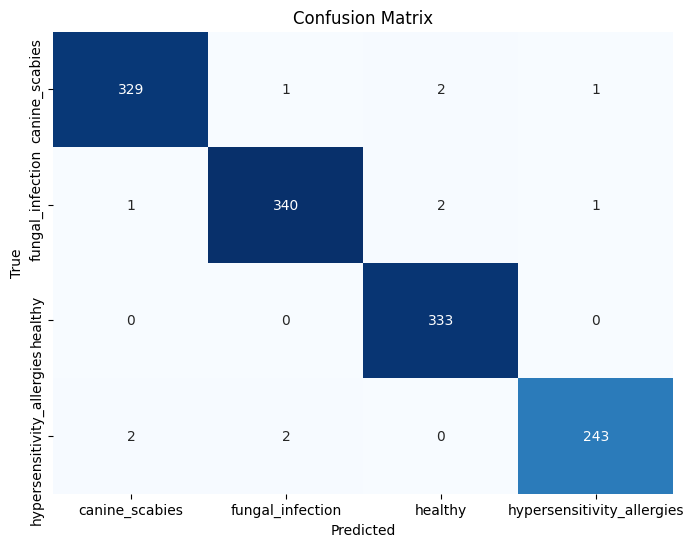

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Convert one-hot encoded labels to class indices if needed
if correct_labels.ndim > 1:
    correct_labels = np.argmax(correct_labels, axis=1)

# Convert predictions to class indices if they are probabilities
if prediction_mobilenet.ndim > 1:
    prediction_mobilenet = np.argmax(prediction_mobilenet, axis=1)

# Ensure both arrays are integers
correct_labels = correct_labels.astype(int)
prediction_mobilenet = prediction_mobilenet.astype(int)

# List of class names (Modify with your actual class names)
class_names = ['canine_scabies', 'fungal_infection', 'healthy', 'hypersensitivity_allergies']

# Generate Classification Report
print("Classification Report:")
print(classification_report(correct_labels, prediction_mobilenet, target_names=class_names))

# Compute Confusion Matrix
conf_matrix = confusion_matrix(correct_labels, prediction_mobilenet)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [27]:
from keras.models import load_model

load_imagePath = r'E:\Year04\IRP\dataset\dogs\canine_scabies\20240820_115645.jpg'
saved_model = load_model(r'mobileNet_best_model.h5')

In [28]:
image_size = (128 ,128)

<class 'numpy.ndarray'>
[[9.9999952e-01 1.7677131e-07 3.2335898e-08 3.5642677e-07]]
Classification:  canine_scabies
Value 0.9999995


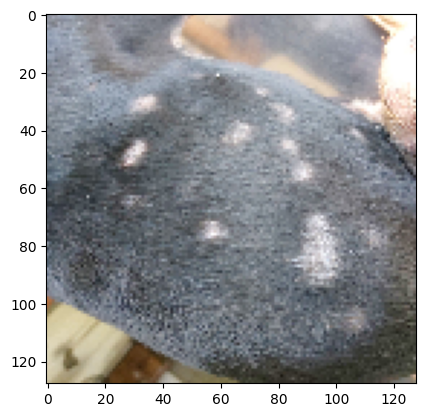

In [29]:
from keras.preprocessing import image

test_img = image.load_img(load_imagePath, target_size = image_size) 
test_image = image.img_to_array(test_img)
test_image = np.expand_dims(test_image, axis = 0)
print(type(test_image))    
result = saved_model.predict(test_image)
print(result)
plt.imshow(test_img) 
print("Classification: ",class_names[int(np.argmax(result,axis=1))])
print("Value", np.amax(result))